# Best Practices - PyTorch ViT on CIFAR100

## Optimizing ViT with NetsPresso Model Compressor
By following this notebook, the user can get ViT which has 1.89x low latency, 2.28x fewer parameters only with 1.12 Top-1 Accuracy drop by using NetsPresso Model Compressor.


This notebook contains the following 3 parts:
  1. [Model Compression with NetsPresso Model Compressor](#1.-Model-Compression-with-NetsPresso-Model-Compressor)
  2. [Fine-Tuning the Compressed Model](#2.-Fine-tuning-the-Compressed-Model)
  3. [Compression-Results](#3.-Compression-Results)
  
For more details about NetsPresso Model Compressor, please visit [Docs](https://docs.netspresso.ai/docs/technology-support-1) and [Netspresso.ai](https://www.netspresso.ai).


<div align="center">
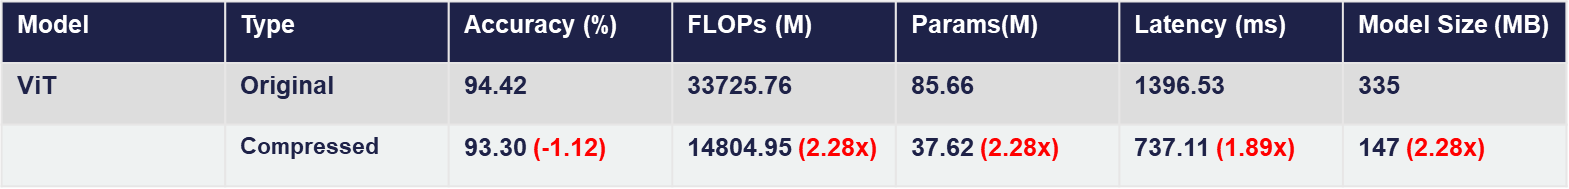
</div>
<div align='center'>
Fig. 1 Compression results of the ViT. The model's latency is measured using a Raspberry Pi 4B (1.5GHz ARM Cortex). We set the model's data type to FP32, and an inference engine to ONNX Runtime to measure the latency.
</div>

<a name="1.-Model-Compression-with-NetsPresso-Model-Compressor"></a>
# 1. Model Compression with NetsPresso Model Compressor

### Setting up your environment


Cloning the ViT code ([link](https://github.com/huggingface/transformers))

In [1]:
! git clone https://github.com/huggingface/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 118344, done.
remote: Total 118344 (delta 0), reused 0 (delta 0), pack-reused 118344
Receiving objects: 100% (118344/118344), 111.97 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (88312/88312), done.


Installing the following packages:

Note: Restart the runtime in order to use the following packages when you run this notebook in Google Colab.



In [2]:
# You MUST install the compatible torch version with your cuda version. Here, we set PyTorch 1.11.0 with CUDA 11.3 as default. (Support: PyTorch version >= 1.10) 
! pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
! pip install scikit-learn
! pip install onnxruntime
! pip install datasets

! cd transformers && \
python setup.py develop

running develop
/opt/conda/envs/vit/lib/python3.8/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/opt/conda/envs/vit/lib/python3.8/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running egg_info
creating src/transformers.egg-info
writing src/transformers.egg-info/PKG-INFO
writing dependency_links to src/transformers.egg-info/dependency_links.txt
writing entry points to src/transformers.egg-info/entry_points.txt
writing requirements to src/transformers.egg-info/requires.txt
writing top-level names to src/transformers.egg-info/top_level.txt
writing manifest file 'src/transformers.egg-info/SOURCES.txt'
reading manifest file 'src/transformers.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license fil

### Preparing the model

Here, we provide CIFAR100 pretrained ViT (graphmodule format). 
* You can check the details of how to get CIFAR100 pretrained ViT model in [Appendix 1](#Appendix-1.-Transfer-Learning-on-CIFAR100).

In [ ]:
! wget Model.pt
! wget Model_ViT.pt

### **ViT compression using NetsPresso Model Compressor**

<a name='compGuide'></a>

__Compression Guide__ 
1. Sign up for NetsPresso Model Compressor ([link](https://compression.netspresso.ai/#/login)).
2. Upload the original ViT. The model should be converted into the `GraphModule (torch.fx.GraphModule)` format. Please check the below [code block](#Conversion-into-GraphModule-Format) to convert the model.
3. To reproduce the best practice result, please select the following compression procedures one by one as depicted [here](#2.-Fine-tuning-the-Compressed-Model): 
    * `Singular Vector Decomposition` &rarr; `Recommendation(VBMF) calibration ratio: 0.2`
        
4. Press `Compress` button, and get the compressed model. The compression result will be shown as follow.

<div align='center'>
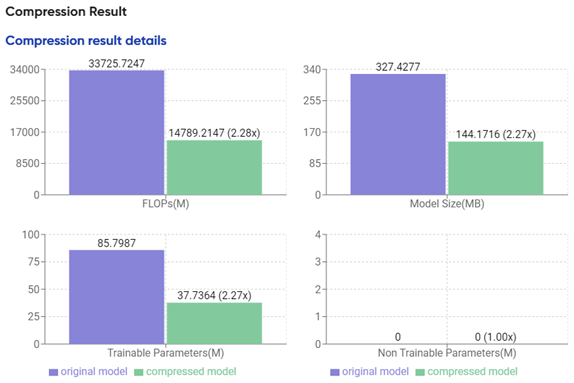
</div>
<div align='center'>
Fig 2. The results of each compression. Compression method: Singular Vector Decomposition (calibration ratio: 0.2)
</div>

<a name="2.-Fine-tuning-the-Compressed-Model"></a>
# 2. Fine-tuning the Compressed Model
Singular Vector Decomposition may induce the performance degradation, which requires additional fine-tuning process.  
Therefore, the fine-tuning process is necessary to compensate the performance after each compression process.  
Here, `Singular Vector Decomposition` &rarr; `Fine-tuning`

<a name="Preparing-CIFAR100-dataset"></a>
### Preparing CIFAR100 dataset

In [6]:
import torch
from datasets import load_dataset, load_metric
from transformers import ViTFeatureExtractor

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize,
                                    ToTensor,
                                    RandAugment)

# load dataset
dataset = load_dataset('cifar100')
image = dataset["train"]["img"]

train_ds = dataset["train"]
test_ds = dataset["test"]


# load feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


def transform(example_batch):
    def toRGB(image):
        if image.mode != 'RGB':
            return image.convert("RGB")
        return image
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([toRGB(x) for x in example_batch['img']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['coarse_label']
    return inputs

prepared_ds = dataset.with_transform(transform)

labels = dataset['train'].features['coarse_label'].names

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

_train_transforms = Compose(
        [
            Resize([feature_extractor.size["width"], feature_extractor.size["height"]]),
            # RandomResizedCrop([feature_extractor.size["width"], feature_extractor.size["height"]]),
            RandomHorizontalFlip(),
            RandAugment(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize([feature_extractor.size["width"], feature_extractor.size["height"]]),
            # CenterCrop([feature_extractor.size["width"], feature_extractor.size["height"]]),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    examples['label'] = examples['coarse_label']
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    examples['label'] = examples['coarse_label']
    return examples


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)


Found cached dataset cifar100 (/root/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142)
100%|██████████| 2/2 [00:00<00:00, 228.55it/s]


### Fine-tuning the compressed model

In this notebook, we fine-tune ([link](#2.-Fine-tuning-the-Compressed-Model)) and verify ([link](#3.-Compression-Results)) the model for the best practice case of Fig. 1 by default.  
* `ViT_compressed_model_SVD_02.pt` means the model compressed by `Singular Vector Decomposition (calibration ratio: 0.2)`.

In [7]:
import torch
import numpy as np
from transformers import TrainingArguments, Trainer, ViTFeatureExtractor
from datasets import load_dataset, load_metric

# Load compressed model
model = torch.load('Model.pt')
_vit_model = torch.load('Model_ViT_compressed_model_SVD_02.pt')
model.vit = _vit_model

# training arguments
training_args = TrainingArguments(
  output_dir=f"./{'ahamed'}",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=1,
  fp16=False,
  save_steps=392,
  eval_steps=392,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  eval_accumulation_steps=30,
)

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions[0], axis=1), references=p.label_ids)


compressed_trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
)

# predict before training
predictions = compressed_trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

# training
train_results = compressed_trainer.train()
compressed_trainer.save_model()
compressed_trainer.log_metrics("train", train_results.metrics)
compressed_trainer.save_metrics("train", train_results.metrics)
compressed_trainer.save_state()

# predict after training
predictions = compressed_trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

# save compressed model
torch.save(compressed_trainer.model, "Model_ViT_finetuned.pt")
torch.save(compressed_trainer.model.vit, "Model_ViT_compressed_model_SVM_02_finetuned.pt")

***** Running Prediction *****
  Num examples = 10000
  Batch size = 64
/opt/conda/envs/vit/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/root/workspace/ViT_bestPractice/transformers/src/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50000
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 7820
  Number of trainable parameters = 37791764


{'accuracy': 0.8472}


/opt/conda/envs/vit/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

<a name="3.-Compression-Results"></a>
# 3. Compression Results

In this section, we visualize and verify the effectiveness of the NetsPresso Model Compressor on ViT.

* [Visualizing the optimization process](#Visualizing-the-optimization-process-on-ViT)
* [Accuracy](#Accuracy-comparision)
* [FLOPs and parameters](#FLOPs-&-Parameters-comparision)
* [Latency](#Latency-comparision)
* [Architecture of the compressed model](#Architecture-of-the-compressed-model)

<a name='Visualizing-the-optimization-process-on-ViT'></a>

<!-- ### Visualization of How NetsPresso Model Compressor Optimizes MobileNetV1 -->
### Visualizing the optimization process on ViT

Fig.3 visualizes part of the original and decomposed ViT.
Here, we applied [L2 Norm Pruning](https://docs.netspresso.ai/docs/pruning#structured-pruning) to optimize the model.
<div align="center">

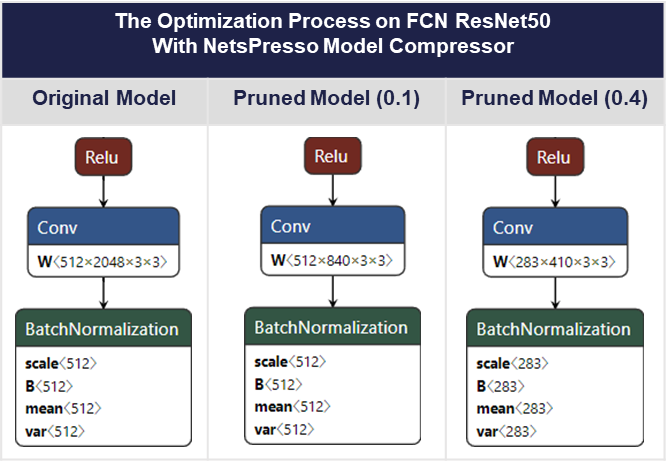
</div>
<div align='center'>Fig. 3 The optimization process for a single convolutional neural network in FCN ResNet50 with NetsPresso Model Compressor</div>

Loading original & compressed models

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

original_model = torch.load('Model.pt',map_location = device)
_original_vit_model = torch.load('Model_ViT.pt',map_location = device)
original_model.vit = _original_vit_model

compressed_model = torch.load("Model_ViT_finetuned.pt",map_location = device)
_compressed_model_vit_model = torch.load("Model_ViT_compressed_model_SVM_02_finetuned.pt",map_location = device)
compressed_model.vit = _compressed_model_vit_model

<a name="Accuracy-comparision"></a>
### Accuracy comparision

Evaluation code for the original model

In [ ]:
training_args = TrainingArguments(
  output_dir=f"./{'ahamed'}",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=0,
  fp16=False,
  save_steps=392,
  eval_steps=392,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  eval_accumulation_steps=30,
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
)

# predict 
predictions = trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

Evaluation code for the compressed model

In [ ]:
training_args = TrainingArguments(
  output_dir=f"./{'ahamed'}",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=0,
  fp16=False,
  save_steps=392,
  eval_steps=392,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  eval_accumulation_steps=30,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
)

# predict
predictions = trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

<a name="FLOPs-&-Parameters-comparision"></a>
### FLOPs & Parameters comparision

In [ ]:
from thop import profile

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dummy_input = torch.ones((1,3,224,224)).to(device)

original_macs, original_params = profile(original_model, inputs=(dummy_input, ))
compressed_macs, compressed_params = profile(compressed_model, inputs=(dummy_input, ))

print("\n--- Original model ==> Compressed model ---")
print(f"FLOPs: {original_macs*2} ==> {compressed_macs*2} (x{round(original_macs/compressed_macs,3)})")
print(f"Params: {original_params} ==> {compressed_params} (x{round(original_params/compressed_params,3)})")

### Latency comparision

In [ ]:
import onnx
def onnxExport(model, model_name, device = torch.device('cpu')):
    model = model.to(device.type)
    dummy_input = torch.ones((1,3,224,224)).to(device.type)
    torch.onnx.export(model,dummy_input,model_name,verbose=False)

onnxExport(original_model, 'ViT_original.onnx')
onnxExport(compressed_model, 'ViT_compressed_model_SVD_02.onnx')

In [ ]:
import onnxruntime
import numpy as np

def inference_time(model_path,run_times):
    device = torch.device('cpu')
    img_size = 520
    so = onnxruntime.SessionOptions()
    so.execution_mode = onnxruntime.ExecutionMode.ORT_SEQUENTIAL
    so.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
    exproviders = [ 'CPUExecutionProvider']
    ort_session = onnxruntime.InferenceSession(model_path, so, providers=exproviders)

    input_names = ort_session.get_inputs()[0].name
    output_names = ort_session.get_outputs()[0].name
    # warm up
    dummy_input = np.random.rand(1,3,img_size,img_size).astype(np.float32)
    for _ in range(10):
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding = ort_session.io_binding()
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        torch.cuda.synchronize()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    latency = []
    for _ in range(run_times):
        dummy_input = np.random.rand(1,3,img_size,img_size).astype(np.float32)
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        start.record() 
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        end.record()
        torch.cuda.synchronize()
        time_elapsed = start.elapsed_time(end)
        latency.append(time_elapsed)
    return sum(latency)/len(latency)


original_latency = inference_time('ViT_original.onnx',run_times=10)
compressed_latency = inference_time('ViT_compressed_model_SVD_02.onnx',run_times=10)

print("Original Model ==> Compressed Model")
print(f"Latency: {round(original_latency,3)}ms ==> {round(compressed_latency,3)}ms (x{round(original_latency/compressed_latency,3)})")

In [ ]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

summary(compressed_model.to(device),(3,224,224),device=device)

<a name='Appendix-1.-Transfer-Learning-on-CIFAR100'></a>
# Appendix 1. Transfer Learning on CIFAR100
In this section, we provide the details of how to get CIFAR100 pretrained ViT.

### Transfer Learning

To do transfer learning the ImageNet pretrained ViT model on CIFAR100, we need to define the modeling for CIFAR100.  
You can get the modeling code `modeling_vit_nptk.py` by running the following code block. You can see details of the modeling in [Appendix 2]().

In [ ]:
! cd transformers/src/transformers/models/vit && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/vit/best_practices/classification/torch/vit/modeling_vit_nptk.py

Praparing the dataset

- Plase run this [code block](#Preparing-CIFAR100-dataset) to prepare the dataset.

Transfer learning

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

import torch
import time
import numpy as np
from torch import nn
from transformers.models.vit.modeling_vit_nptk import ViTForImageClassificationNptk
from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification, Trainer
from transformers import TrainingArguments
from transformers.utils.fx import symbolic_trace
from datasets import load_dataset, load_metric
from torch.profiler import profile, record_function, ProfilerActivity
from torch.profiler import schedule
from torch.profiler import tensorboard_trace_handler

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize,
                                    ToTensor,
                                    RandAugment)




model = ViTForImageClassificationNptk.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    # "Ahmed9275/Vit-Cifar100",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

training_args = TrainingArguments(
  output_dir=f"./{'ahamed'}",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=0,
  fp16=False,
  save_steps=392,
  eval_steps=392,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  eval_accumulation_steps=30,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
)

# predict before training
predictions = trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

# # training
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# # predict after training
predictions = trainer.predict(prepared_ds['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
result = metric.compute(predictions=preds, references=predictions.label_ids)
print(result)

torch.save(trainer.model.vit, "Model_ViT.pt")
torch.save(trainer.model, "Model.pt")

<a name="Conversion-into-GraphModule-Format"></a>
### Conversion into GraphModule format

In [ ]:
import torch
from transformers.utils.fx import symbolic_trace

vit_model = trainer.model.vit

traced = symbolic_trace(vit_model, ["pixel_values"])
graph = torch.fx.Tracer().trace(traced)

traced_model = torch.fx.GraphModule(traced, graph)
torch.save(traced_model,"Model_ViT.pt")

<a name="Appendix 2."></a>
# Appendix 2. Description of The Modifications
In this section, we go into detail about the code we've changed for transfer learning.

* `modeling_vit_nptk.py`
    * To convert ViT model into Graphmodule format, we need to check the input value by using `torch._assert`, not `if statement` [(link 1)](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/9da4098151a190b91824ffe4ea8ba0e19053ea74#diff-b280caff67c6b17613012f9ffc6d92dcddc8ed5275fe6ebfab84bc9b1041345dL176), [(link 2)](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/9da4098151a190b91824ffe4ea8ba0e19053ea74#diff-b280caff67c6b17613012f9ffc6d92dcddc8ed5275fe6ebfab84bc9b1041345dR180), [(link 3)](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/9da4098151a190b91824ffe4ea8ba0e19053ea74#diff-b280caff67c6b17613012f9ffc6d92dcddc8ed5275fe6ebfab84bc9b1041345dR185).
    * As ViT model is converted into Graphmodule format, the type of ViT model's output changes to `dict`. Therefore, 
        *  we change the input parameters for the `vit module` [(link)](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/9da4098151a190b91824ffe4ea8ba0e19053ea74#diff-b280caff67c6b17613012f9ffc6d92dcddc8ed5275fe6ebfab84bc9b1041345dR799) and 
        * the parameters of `ImageClassifierOutput` [(link)](https://github.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/commit/9da4098151a190b91824ffe4ea8ba0e19053ea74#diff-b280caff67c6b17613012f9ffc6d92dcddc8ed5275fe6ebfab84bc9b1041345dR833).